<a href="https://colab.research.google.com/github/dr-richard-barker/image-analysis-software-and-R-codes/blob/master/Spectrum_RFP_Basic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intensity Analysis With PlantCV

Hello everyone! I'd like to share my preliminary work with plantcv. (I put this on colab to be able to share it nicely without everybody having to run an instance of jupyterlab but the drawback is running any of the scripts breaks them. That being said, the current code as it is will output what is shown in the notebook.)

In [ ]:
from google.colab import drive
drive.mount("mnt", force_remount=True)

Need to add some more code here to specify would images are going to be loaded in.

In [ ]:
# Import Libraries
from plantcv import plantcv as pcv
import matplotlib
import numpy as np

## Introduction
In a nutshell, plantcv allows people to bind together powerful image analysis tools into "pipelines" which receives images, processes them and outputs relevant measurments. This particular ipython notebook looks into try tackle this particular challenge outlined the notes that came with the images.

```"It may be possible to get intensity changes in each root from the GFP and RFP channels, and an average intensity for each line."```

Here I'm only looking at the analysis of one whole plant in one image but I think this can easily be scaled up targeted to specific portions of the plant. I'll discuss how in the conclusion and update the slack as I progress. I chose one of the RFP plants since they were the cleanest to analyze.

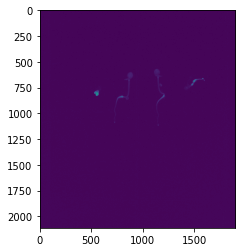

In [ ]:
img = matplotlib.pyplot.imread("./SPECTRUM/RFP/crop_01446_2019_06_02__00_09_08_Mono.tif") #The image to analyze
height, width = img.shape

# Crops the image in half to make it easier to work with. I'll touch more on why I think this is necessary in another
# notebook where I think it'll be more relevant
height_cutoff = height // 2

t_img = img[:height_cutoff, :]
b_img = img[height_cutoff:, :]

matplotlib.pyplot.imshow(b_img)
# Here I'm going to work with the bottom part of the petri dish containing the relevant ZAT::GFP plus UBI::mCherry
# RFP related plants

## Rescaling
Here I am rescaling the image to the default image colorspace where each pixel is given a value from 0-255 rather then the original values. For comparison you can see the output of the original tiff file below

In [ ]:
print(b_img)

[[1216  224  400 ...   96  672  544]
 [ 256    0 1184 ... 1088  208  640]
 [   0  992  704 ...  992  592    0]
 ...
 [1040  432 1616 ... 3248  768 1312]
 [ 320  816 1520 ... 1344 1536  960]
 [ 640  560 1232 ... 1392  976  304]]


I'm not exactly sure what meaning these pixel values have (other then the light value of course). Here I'm treating them like arbritrary light value where the relative brightness of the pixel is more important then the individual value of the pixel but if you have any information about the storage format of SPECTRUM images I would love to hear it.

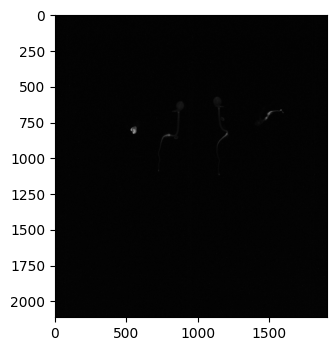

In [ ]:
# Rescale the thermal data to a colorspace with range 0-255

# Inputs:
#   gray_img - Grayscale image data
#   min_value - New minimum value for range of interest. default = 0
#   max_value - New maximum value for range of interest. default = 255

pcv.params.debug = "plot" #prints plots to the notebook so I can see my steps
scaled_rfp_img = pcv.transform.rescale(gray_img=b_img)

## Thresholding
Once I get a picture I have to threshold it to separate the background and noise from the plant itself. Here I remove any pixels that have value lower then 10 to remove the background of these photos. THen I use a fill command to eliminate any remaining background noise in the image.

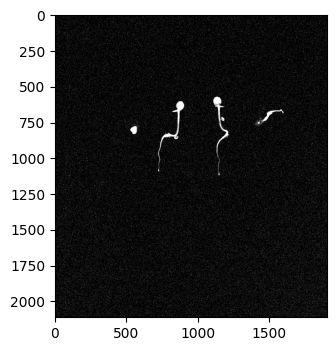

In [ ]:
# Thresholding with pixel value
b_thresh = pcv.threshold.binary(gray_img=scaled_rfp_img, threshold=10, max_value=255, object_type='light')

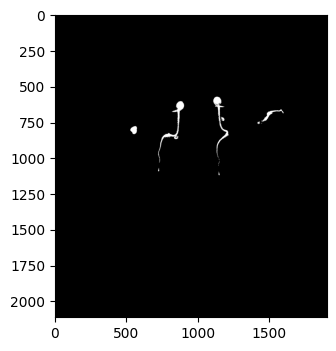

In [ ]:
# Remove all areas smaller then 10 pixels to remove background noise
ab_fill = pcv.fill(bin_img=b_thresh, size=10)

## Objects
Here you can see me telling the computer what areas count as a plant (highlighted in pink)

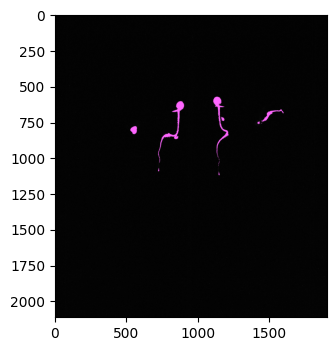

In [ ]:
id_objects, obj_hierarchy = pcv.find_objects(img=scaled_rfp_img, mask=ab_fill)

## Region of Interest

After that I choose the relevant regions of the photo to do my analysis. In this example I chose the plantthird to the left. You can actually see in the image (which depicts the orignal photo) how much noise we cleaned up during thresholding.

After selecting the proper region of intrest I can separate only the relevant portions of my picture to do analysis.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


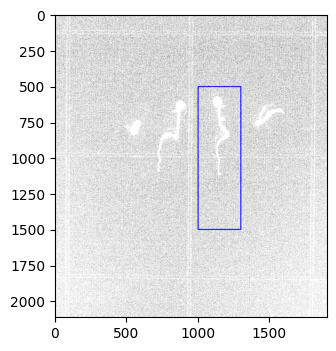

In [ ]:
#roi1, roi_hierarchy1 = pcv.roi.rectangle(img=b_img, x=400, y=500, h=1000, w=300)
#roi2, roi_hierarchy2 = pcv.roi.rectangle(img=b_img, x=700, y=500, h=1000, w=300)
roi3, roi_hierarchy3 = pcv.roi.rectangle(img=b_img, x=1000, y=500, h=1000, w=300)
#roi4, roi_hierarchy4 = pcv.roi.rectangle(img=b_img, x=1300, y=500, h=1000, w=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


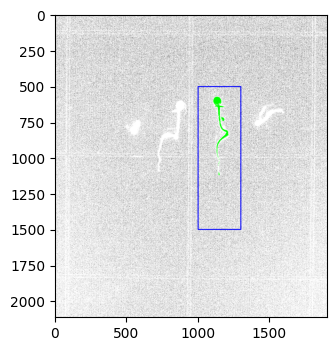

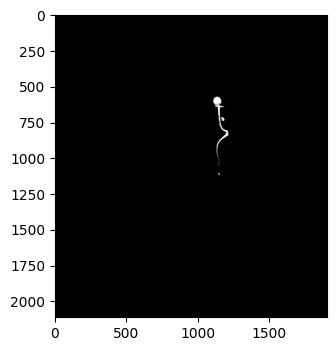

"\nroi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=b_img, roi_contour=roi4, \n                                                                   roi_hierarchy=roi_hierarchy4, \n                                                                   object_contour=id_objects, \n                                                                   obj_hierarchy=obj_hierarchy,\n                                                                   roi_type='partial')\n"

In [ ]:
"""
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=b_img, roi_contour=roi1,
                                                                   roi_hierarchy=roi_hierarchy1,
                                                                   object_contour=id_objects,
                                                                   obj_hierarchy=obj_hierarchy,
                                                                   roi_type='partial')
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=b_img, roi_contour=roi2,
                                                                   roi_hierarchy=roi_hierarchy2,
                                                                   object_contour=id_objects,
                                                                   obj_hierarchy=obj_hierarchy,
                                                                   roi_type='partial')
"""

roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=b_img, roi_contour=roi3,
                                                                   roi_hierarchy=roi_hierarchy3,
                                                                   object_contour=id_objects,
                                                                   obj_hierarchy=obj_hierarchy,
                                                                   roi_type='partial')
"""
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=b_img, roi_contour=roi4,
                                                                   roi_hierarchy=roi_hierarchy4,
                                                                   object_contour=id_objects,
                                                                   obj_hierarchy=obj_hierarchy,
                                                                   roi_type='partial')
"""

## Analysis
Finally, the analysis part of the setup!. This is where all the exciting stuff happens. First I run the image through the nir intensity analysis function. You might say "wait a min? NIR" and you're right. This is not a NIR photo but I think it was made for monocolored photos similar to this one and it seems to do it's job well. That being said, I am looking into functions that may work better for these situations.

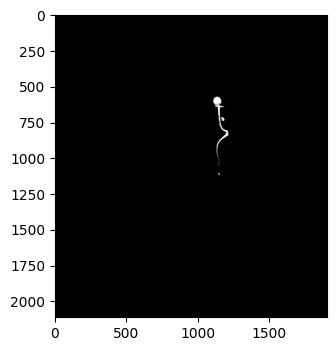

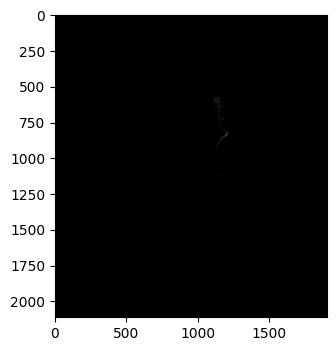

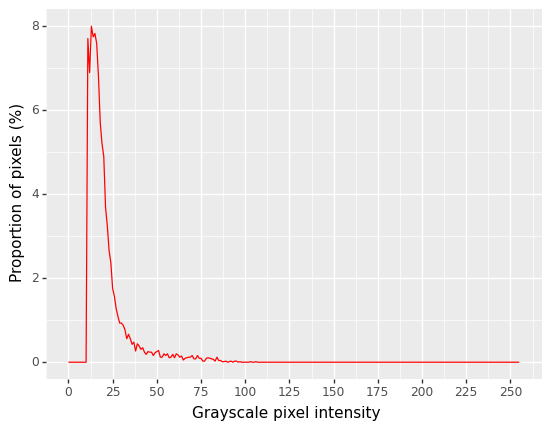

<ggplot: (-9223363259954449043)>


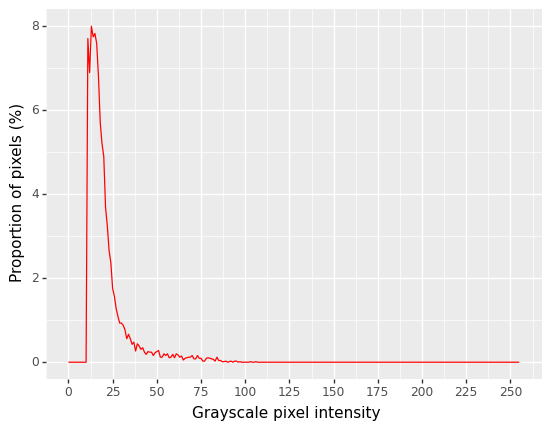

<ggplot: (-9223363259954449043)>

In [ ]:
pcv.analyze_nir_intensity(gray_img=scaled_rfp_img, mask=kept_mask, bins=256, histplot=True)

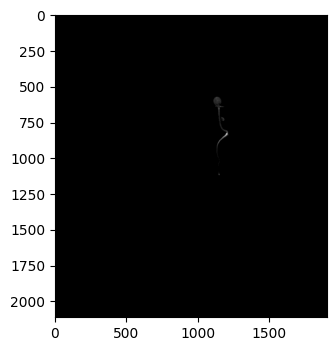

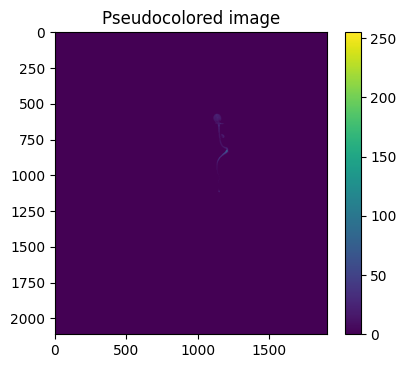

In [ ]:
masked_image = pcv.apply_mask(img=scaled_rfp_img, mask=kept_mask, mask_color='black')
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=masked_image, background="black", cmap='viridis')

## Data Parsing
The NIR analysis function from plant CV does an excellent job plotting histograms and analyzing the information but once it outputs there is a whole lot more that can be gotten out of it. The analysis itself outputs histogram data in 'bins' contained in the list 'label' with a corresponding value of instances of that label contained in the list named 'value'. Here I parse this out and get the minimum, maximum, mean, standard deviation and median of the pixel values in this plant

In [ ]:
print(pcv.outputs.observations)

{'nir_frequencies': {'trait': 'near-infrared frequencies', 'method': 'plantcv.plantcv.analyze_nir_intensity', 'scale': 'frequency', 'datatype': "<class 'list'>", 'value': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 579.0, 518.0, 601.0, 582.0, 588.0, 570.0, 511.0, 429.0, 391.0, 368.0, 277.0, 244.0, 200.0, 178.0, 132.0, 118.0, 96.0, 82.0, 70.0, 70.0, 66.0, 58.0, 42.0, 50.0, 42.0, 32.0, 36.0, 20.0, 33.0, 29.0, 23.0, 26.0, 18.0, 14.0, 19.0, 18.0, 18.0, 12.0, 17.0, 19.0, 21.0, 9.0, 9.0, 15.0, 12.0, 15.0, 8.0, 9.0, 14.0, 8.0, 15.0, 13.0, 9.0, 11.0, 4.0, 7.0, 8.0, 9.0, 9.0, 12.0, 6.0, 6.0, 12.0, 7.0, 7.0, 2.0, 2.0, 7.0, 8.0, 7.0, 6.0, 5.0, 2.0, 9.0, 3.0, 3.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
obs = pcv.outputs.observations['nir_frequencies']
obs_hist = dict(zip(obs['label'], obs['value']))

In [ ]:
dataset=[]

for bins in obs_hist.keys():
    dataset.extend([bins]*int(obs_hist[bins]))
print(dataset)

[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.

In [ ]:
print("minimum: {}".format(np.min(dataset)))
print("maximum: {}".format(np.max(dataset)))
print("mean: {}".format(np.mean(dataset)))
print("std: {}".format(np.std(dataset)))
print("median {}".format(np.median(dataset)))

minimum: 11.0
maximum: 106.0
mean: 20.87857427849448
std: 12.278510570377579
median 17.0


## Conclusion
I belive there is a strong case for using PlantCV in this analysis. It has shown to be able to do the job well in a simple yet intuitive way. There are some big issues with including the difficulty it has reading RGB images in different light conditions and how the grids of the petri dish affect image analysis but I wish to tackle that in a different notebook. I was not able to analyze multiple plants or do anything beyond basic analysis simply because I did not have much time to put this together today but scaling this up seems pretty simple. Eventually I want to be able to isolate the shoots or the roots of a plant using RGB images and covering up certain portions of the images so that you can look at the just the roots or just the shoots. I started something regarding that but it's facing some difficulties at the moment but I'll post it on slack as soon as I write all my notes for it (probably monday) I'm excited to hear all of your feedback and suggestions and more notebooks are on their way. Thanks for reading.